## VGG16 Model using Pretrained Weights


### Import Libraries


In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import tensorflow_ranking as tfr
import scipy
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    Add,
    GlobalAveragePooling2D,
    ZeroPadding2D,
)
from tensorflow.keras.layers import Activation, Input, MaxPool2D, concatenate
from tensorflow.keras.layers import (
    Reshape,
    Lambda,
    Flatten,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.metrics import MeanIoU, AUC, Precision, Recall
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


### Initializing Variables


In [2]:
# Model parameters and variables
EPOCHS = 250
BATCH_SIZE = 32
LEARNING_RATE = 0.0003
TARGET_SIZE = 224

# Reading the train, validation and test labels
TRAIN_LABELS = pd.read_csv('train_annot.csv')
TEST_LABELS = pd.read_csv('test_annot.csv')
VAL_LABELS = pd.read_csv('valid_annot.csv')

# Path directories for the training, validation and test data
TRAIN_PATH = '/home/lunet/conm/Desktop/Stenosis-Project/Stenosis_224x224/train'
TEST_PATH = '/home/lunet/conm/Desktop/Stenosis-Project/Stenosis_224x224/test'
VAL_PATH = '/home/lunet/conm/Desktop/Stenosis-Project/Stenosis_224x224/valid'

# Using image data generator to fit the training data to the model
dataGenerator = ImageDataGenerator()

# Implementing an early stopping callback to stop the training if the model loss does not improve further
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Initializing train, validation and test variables
train_images = []
train_targets = []

val_images = []
val_targets = []

test_images = []
test_targets = []


### Check GPU Availability


In [3]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5948861875286334397
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9670623232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5659911171382249153
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2022-08-31 04:19:04.877967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 04:19:04.908654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:04.919366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:04.920123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

### Normalization of Label Data


In [4]:
for index, row in TRAIN_LABELS.iterrows():
    # Initializing the label headers
    (filename, xmin, ymin, xmax, ymax, class_name) = row

    # Reading image from the train folder
    imagePath = os.path.join(TRAIN_PATH, filename)
    pic = cv2.imread(imagePath)

    # Shape of images is 224x224
    (h, w) = pic.shape[:2]

    # Loading image in the target size and converting to array
    pic = load_img(imagePath, target_size=(TARGET_SIZE, TARGET_SIZE))
    pic = img_to_array(pic)

    # Normalizing the box coordinates to the target size
    xmin /= w
    ymin /= h
    xmax /= w
    ymax /= h

    # Appending the image and the box coordinates to the train variables
    train_images.append(pic)
    train_targets.append((xmin, ymin, xmax, ymax))


In [5]:
for index, row in VAL_LABELS.iterrows():
    # Initializing the label headers
    (filename, xmin, ymin, xmax, ymax, class_name) = row

    # Reading image from the validation folder
    imagePath = os.path.join(VAL_PATH, filename)
    pic = cv2.imread(imagePath)
    # Shape of images is 224x224
    (h, w) = pic.shape[:2]

    # Loading image in the target size and converting to array
    pic = load_img(imagePath, target_size=(TARGET_SIZE, TARGET_SIZE))
    pic = img_to_array(pic)

    # Normalizing the box coordinates to the target size
    xmin /= w
    ymin /= h
    xmax /= w
    ymax /= h

    # Appending the image and the box coordinates to the validation variables
    val_images.append(pic)
    val_targets.append((xmin, ymin, xmax, ymax))


In [6]:
for index, row in TEST_LABELS.iterrows():
    # Initializing the label headers
    (filename, xmin, ymin, xmax, ymax, class_name) = row

    # Reading image from the test folder
    imagePath = os.path.join(TEST_PATH, filename)
    pic = cv2.imread(imagePath)

    # Shape of images is 224x224
    (h, w) = pic.shape[:2]

    # Loading image in the target size and converting to array
    pic = load_img(imagePath, target_size=(TARGET_SIZE, TARGET_SIZE))
    pic = img_to_array(pic)

    # Normalizing the box coordinates to the target size
    xmin /= w
    ymin /= h
    xmax /= w
    ymax /= h

    # Appending the image and the box coordinates to the test variables
    test_images.append(pic)
    test_targets.append((xmin, ymin, xmax, ymax))


### Python Lists to Numpy Arrays


In [7]:
# Converting the train, validation and test variables to numpy arrays in float32 format
train_images = np.array(train_images, dtype='float32')
train_targets = np.array(train_targets, dtype='float32')

val_images = np.array(train_images, dtype='float32')
val_targets = np.array(train_targets, dtype='float32')

test_images = np.array(train_images, dtype='float32')
test_targets = np.array(train_targets, dtype='float32')


### Normalization of Image Data


In [8]:
train_images /= 255.0
val_images /= 255.0
test_images /= 255.0


In [9]:
print(train_targets[0])
print(val_targets[0])
print(test_targets[0])


[0.46875   0.3794643 0.5089286 0.40625  ]
[0.46875   0.3794643 0.5089286 0.40625  ]
[0.46875   0.3794643 0.5089286 0.40625  ]


### Displaying Stenosis Images


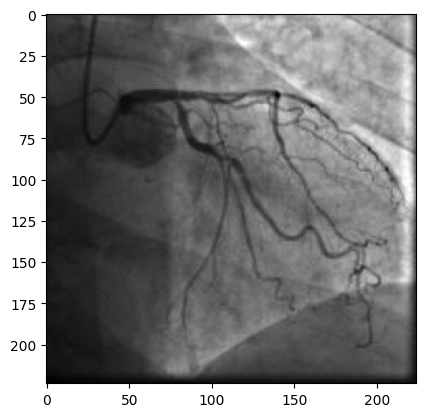

In [10]:
plt.imshow(train_images[0])


### Calculation of Intersection Over Union (IOU) Score


In [11]:
# Reference: https://www.kaggle.com/code/vbookshelf/keras-iou-metric-implemented-without-tensor-drama/notebook

def calculate_iou(y_true, y_pred):
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).

    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.

    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    """
    results = []

    for i in range(0, y_true.shape[0]):
        # Set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)

        # boxTrue
        x_boxTrue_tleft = y_true[0, 0]  # numpy index selection
        y_boxTrue_tleft = y_true[0, 1]
        boxTrue_width = y_true[0, 2]
        boxTrue_height = y_true[0, 3]
        area_boxTrue = boxTrue_width * boxTrue_height

        # boxPred
        x_boxPred_tleft = y_pred[0, 0]
        y_boxPred_tleft = y_pred[0, 1]
        boxPred_width = y_pred[0, 2]
        boxPred_height = y_pred[0, 3]
        area_boxPred = boxPred_width * boxPred_height

        # Calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height  # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height  # Version 2 revision

        # Calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - Top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft, x_boxPred_tleft])
        y_boxInt_tleft = np.max(
            [y_boxTrue_tleft, y_boxPred_tleft]
        )  # Version 2 revision

        # boxInt - bBottom right coords
        x_boxInt_br = np.min([x_boxTrue_br, x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br, y_boxPred_br])

        # Calculate the area of boxInt, i.e. the area of the intersection
        # between boxTrue and boxPred
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.

        # Version 2 revision
        area_of_intersection = np.max([0, (x_boxInt_br - x_boxInt_tleft)]) * np.max(
            [0, (y_boxInt_br - y_boxInt_tleft)]
        )

        iou = area_of_intersection / (
            (area_boxTrue + area_boxPred) - area_of_intersection
        )

        # This must match the type used in py_func
        iou = iou.astype(np.float32)

        # Append the result to a list at the end of each loop
        results.append(iou)

    # Return the mean IoU score for the batch
    return np.mean(results)


def IoU(y_true, y_pred):

    iou = tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou


### Load the VGG16 Model


In [12]:
# Load the VGG16 model and create the head using the Functional API of Keras
vgg_model = VGG16(
    weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3))
)

# Freeze the VGG layers to not be used for training
vgg_model.trainable = False

# Flatten output of the VGG16 model
flatten_Output = vgg_model.output
flatten_Layer = Flatten()(flatten_Output)

# Fully-connected Dense layers to predict the bounding box coordinates
dense_Layer = Dense(128, activation='relu')(flatten_Layer)
dense_Layer = Dense(64, activation='relu')(dense_Layer)
dense_Layer = Dense(32, activation='relu')(dense_Layer)

# Final output layer to predict [xmin, ymin, xmax, ymax]
dense_Output = Dense(4, activation='sigmoid')(dense_Layer)

# Construct the model
model = Model(inputs=vgg_model.input, outputs=dense_Output)


2022-08-31 04:19:14.653999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:14.654844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:14.655590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:14.656555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:19:14.657300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

### Compile and Fit the Model


In [13]:
# Compile the model using mean square error as the loss function, Adam as the optimizer and the IoU and accuracy as the metric
model.compile(loss='mse', optimizer='adam', metrics=['accuracy', IoU])

# Create a model summary
model.summary()

# Visualize the model architecture
plot_model(model, to_file='vgg16_model.png', show_shapes=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Clear the session to prevent clutter from previous runs
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

# Train the VGG16 model
model_Train = model.fit(
    dataGenerator.flow(train_images, train_targets, batch_size=32),
    validation_data=(val_images, val_targets),
    epochs=250,
    callbacks=[es],
    verbose=1,
    shuffle=True,
)


Epoch 1/250


2022-08-31 04:19:15.836653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-08-31 04:19:16.212337: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


183/183 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.6912 - IoU: 0.3974

2022-08-31 04:19:32.873446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3507904512 exceeds 10% of free system memory.
2022-08-31 04:19:34.284524: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3507904512 exceeds 10% of free system memory.


183/183 [==============================] - 33s 159ms/step - loss: 0.0118 - accuracy: 0.6912 - IoU: 0.3974 - val_loss: 0.0041 - val_accuracy: 0.6658 - val_IoU: 0.4778
Epoch 2/250
183/183 [==============================] - 26s 144ms/step - loss: 0.0024 - accuracy: 0.8462 - IoU: 0.5920 - val_loss: 0.0011 - val_accuracy: 0.9346 - val_IoU: 0.6686
Epoch 3/250
183/183 [==============================] - 26s 144ms/step - loss: 0.0012 - accuracy: 0.9156 - IoU: 0.6721 - val_loss: 8.4205e-04 - val_accuracy: 0.9476 - val_IoU: 0.7136
Epoch 4/250
183/183 [==============================] - 26s 145ms/step - loss: 8.3933e-04 - accuracy: 0.9349 - IoU: 0.7185 - val_loss: 0.0016 - val_accuracy: 0.9538 - val_IoU: 0.6345
Epoch 5/250
183/183 [==============================] - 27s 146ms/step - loss: 7.4746e-04 - accuracy: 0.9367 - IoU: 0.7347 - val_loss: 6.8732e-04 - val_accuracy: 0.9514 - val_IoU: 0.7549
Epoch 6/250
183/183 [==============================] - 27s 146ms/step - loss: 8.2736e-04 - accuracy: 0.918

### Visualize the IOU, Accuracy, and Loss Metrics

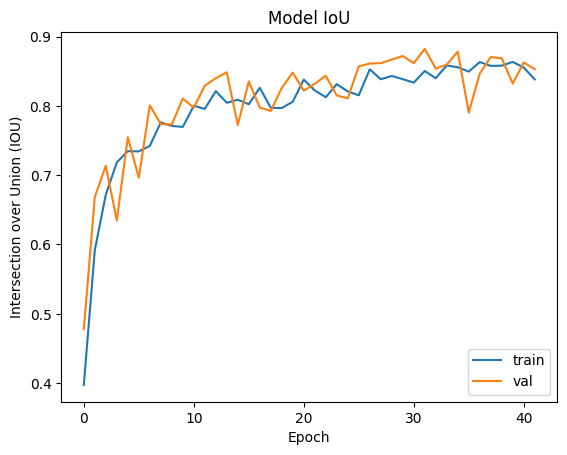

In [15]:
plt.plot(model_Train.history['IoU'])
plt.plot(model_Train.history['val_IoU'])
plt.title('Model IoU')
plt.ylabel('Intersection over Union (IOU)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


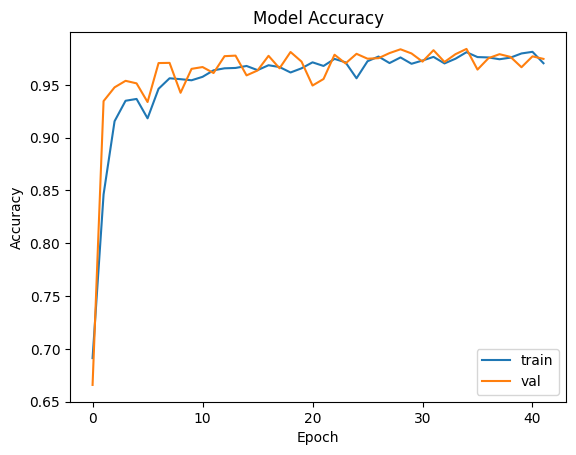

In [16]:
plt.plot(model_Train.history['accuracy'])
plt.plot(model_Train.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

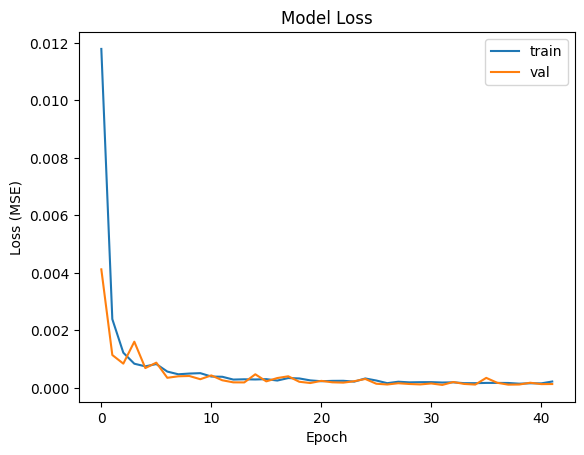

In [17]:
plt.plot(model_Train.history['loss'])
plt.plot(model_Train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()


### Model Evaluation and Prediction Results on Test Data

In [18]:
model.evaluate(test_images, test_targets, verbose=1, batch_size=32)

2022-08-31 04:38:04.956702: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3507904512 exceeds 10% of free system memory.
2022-08-31 04:38:06.365567: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3507904512 exceeds 10% of free system memory.


183/183 [==============================] - 14s 76ms/step - loss: 1.3263e-04 - accuracy: 0.9746 - IoU: 0.8528


[0.0001326297497143969, 0.9745966196060181, 0.8528465628623962]

In [19]:
model.save('vgg16.h5')
model_load = load_model('vgg16.h5', custom_objects={'IoU': IoU})


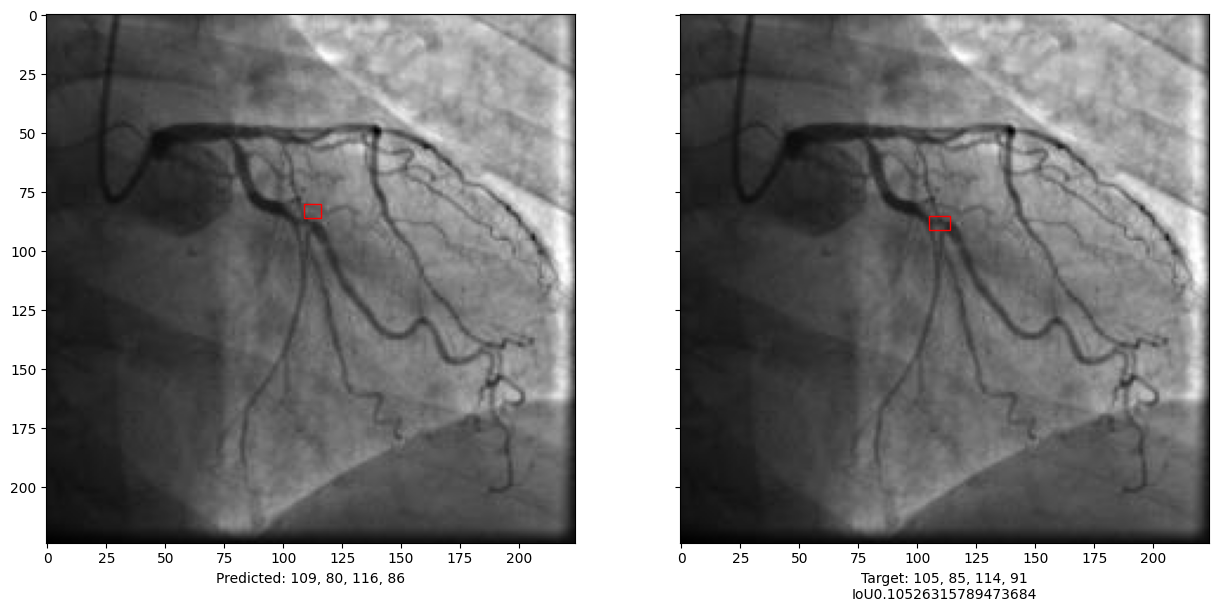

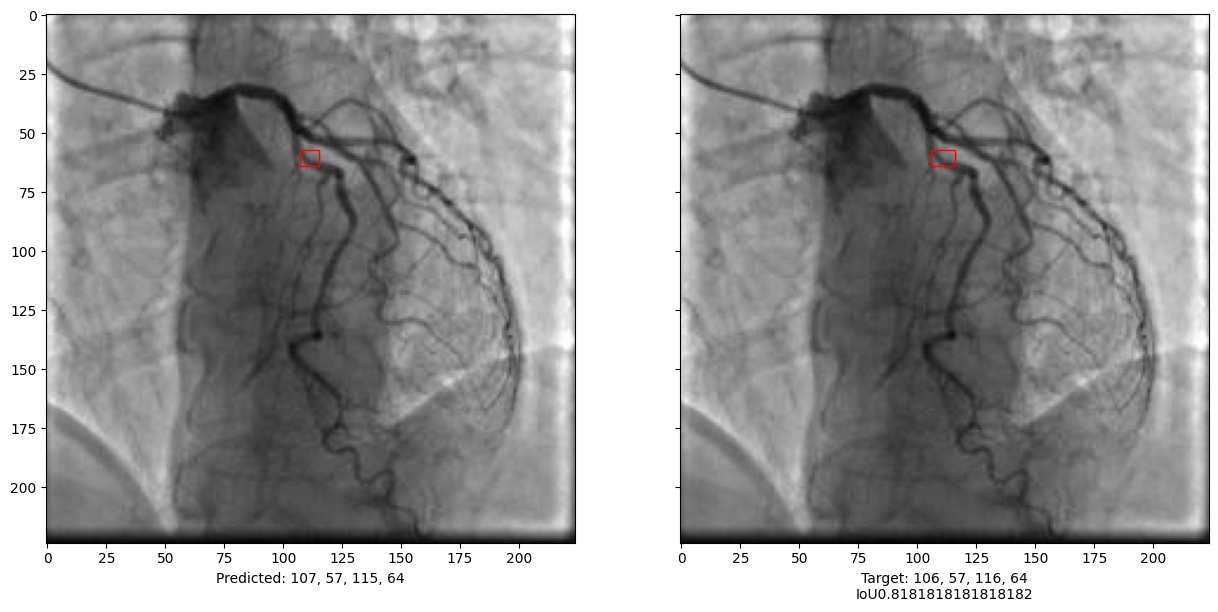

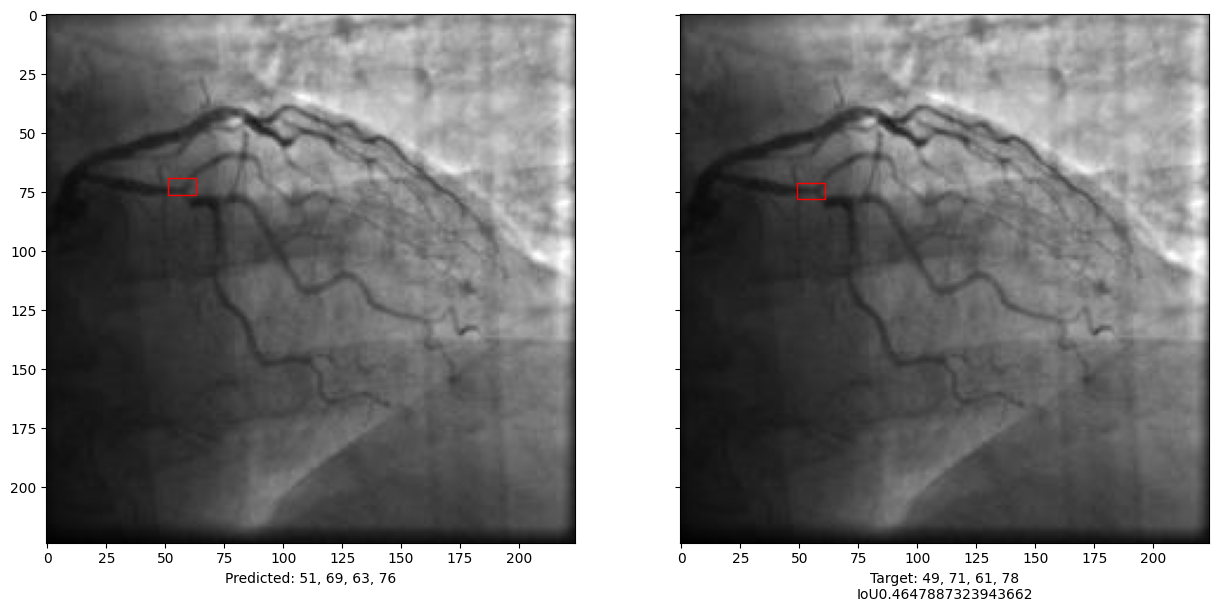

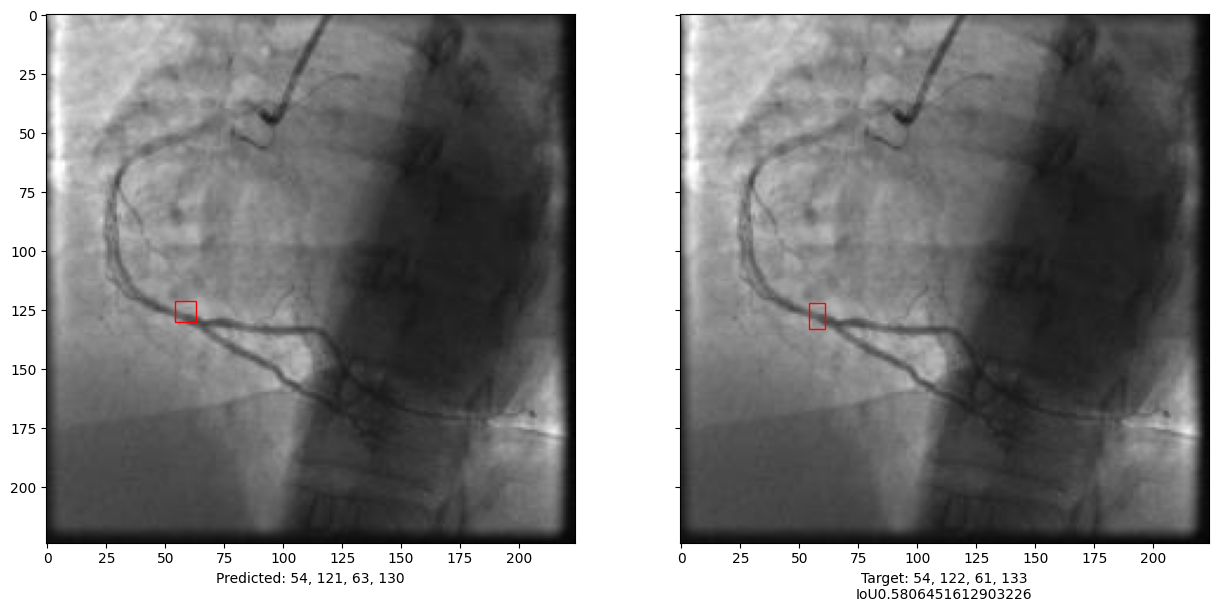

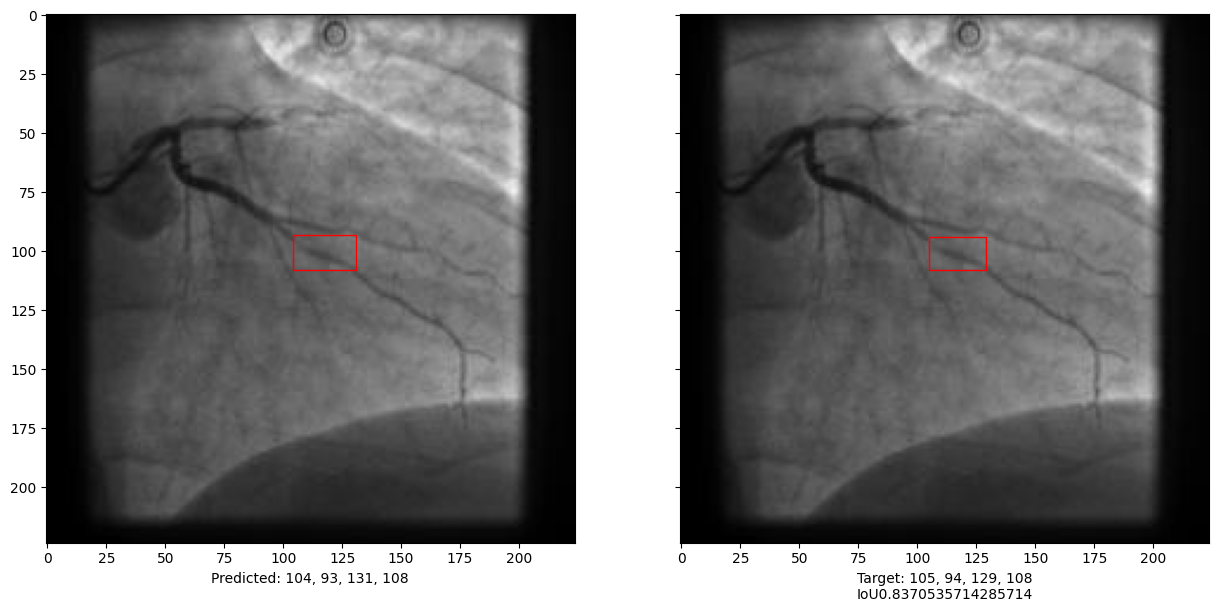

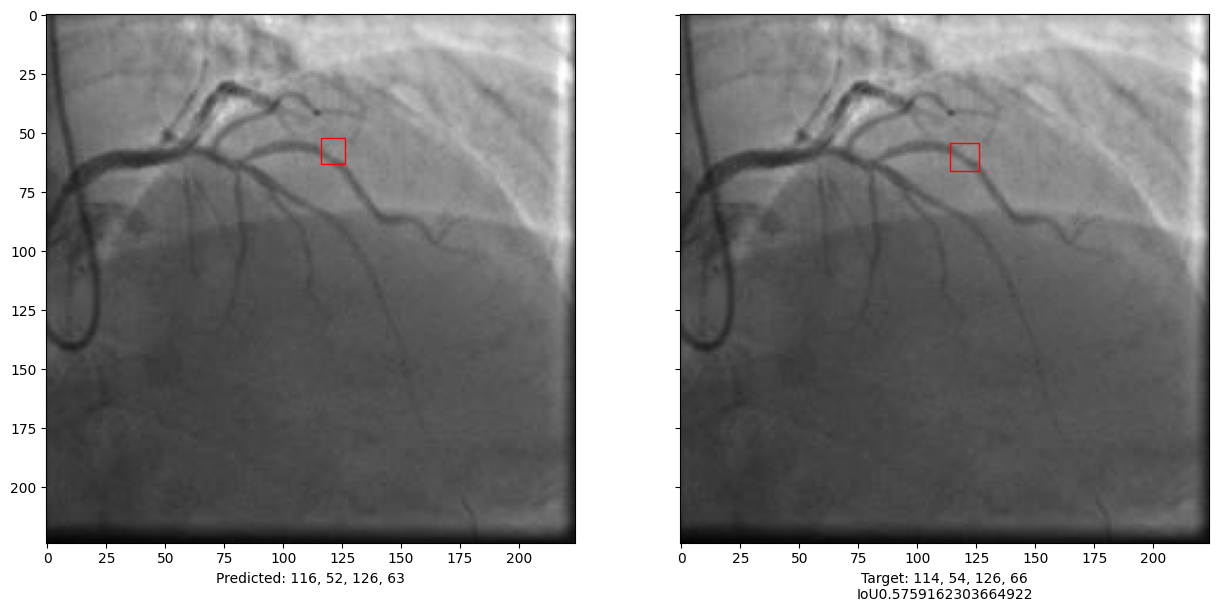

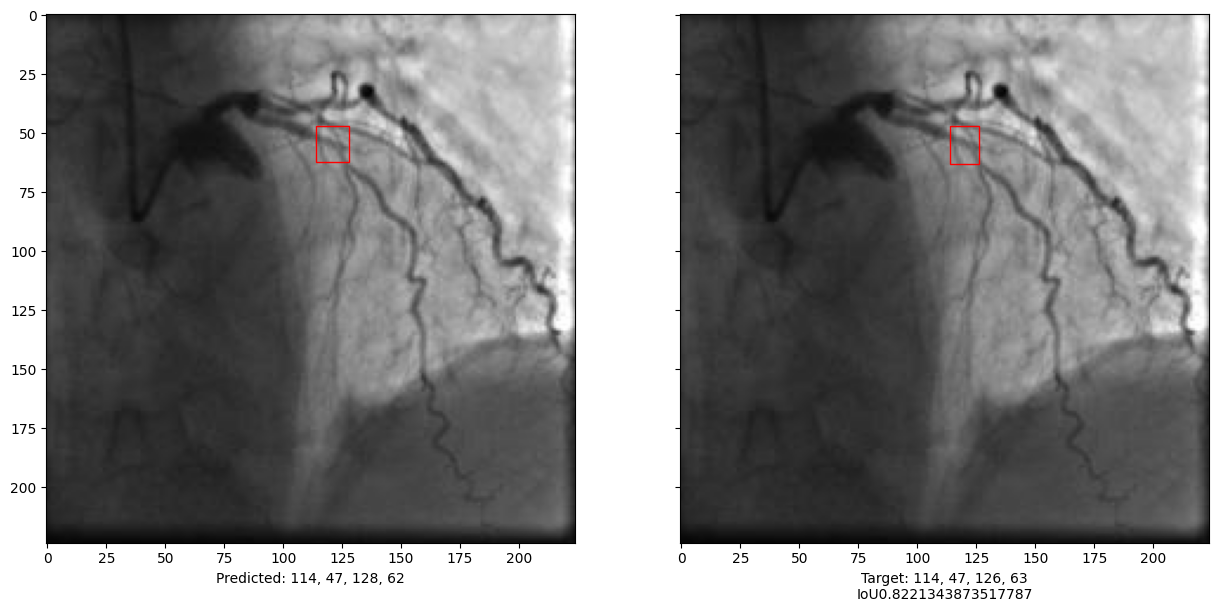

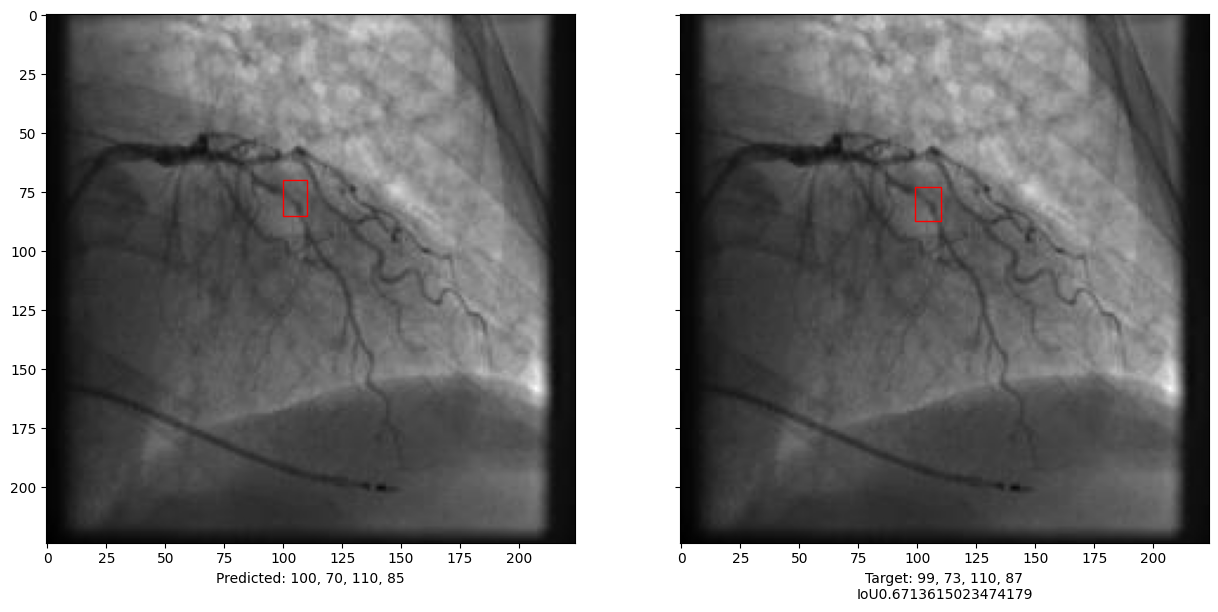

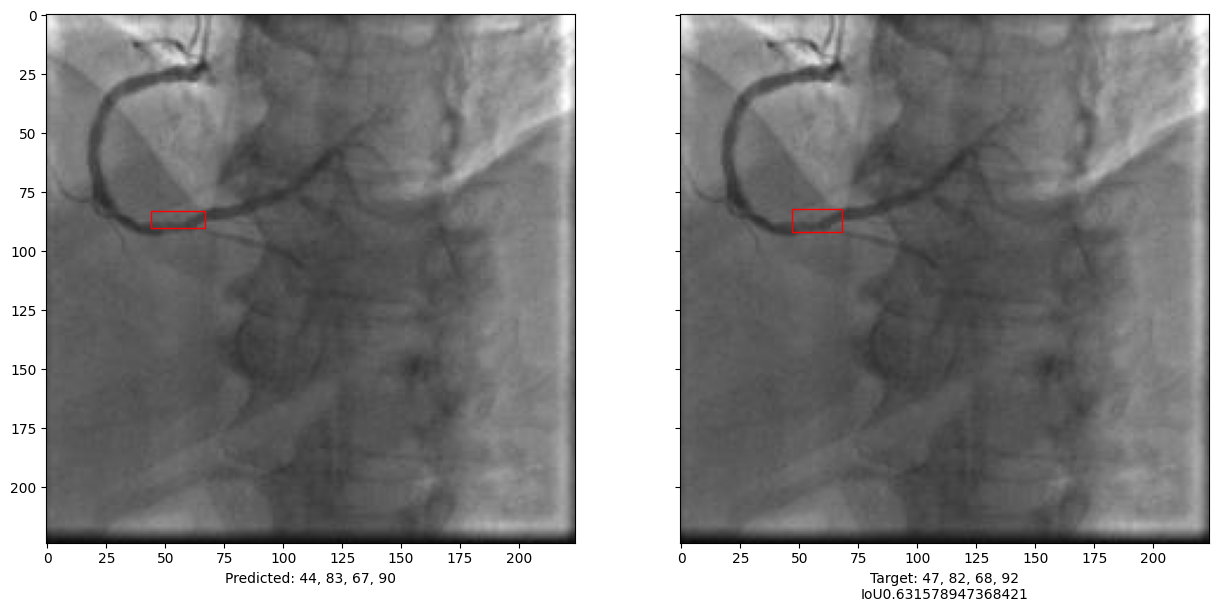

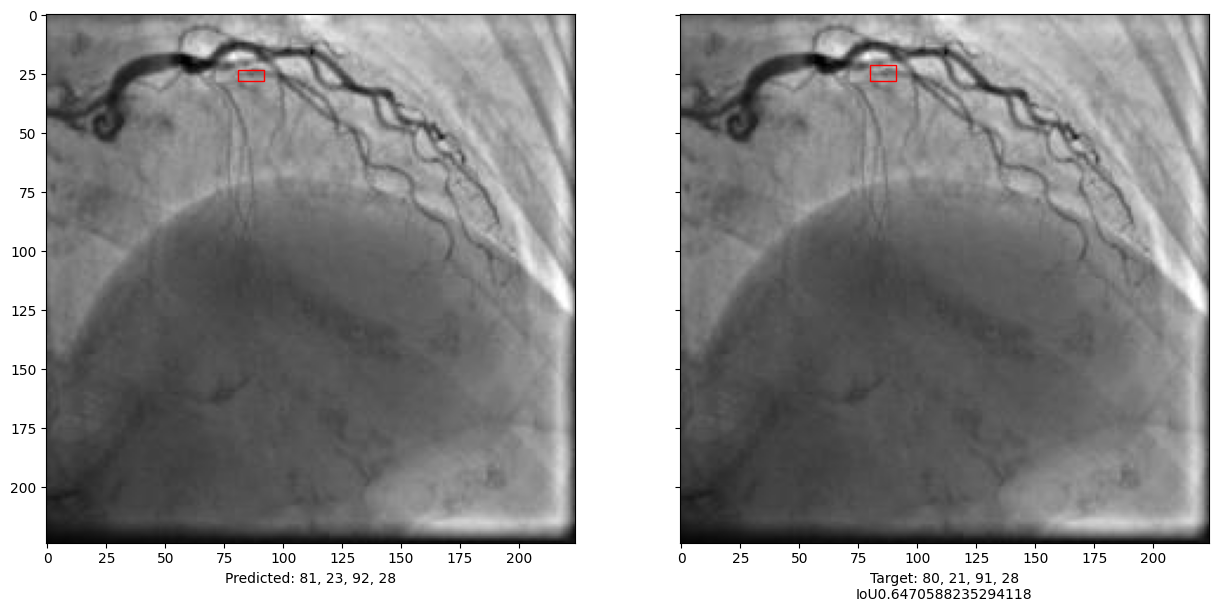

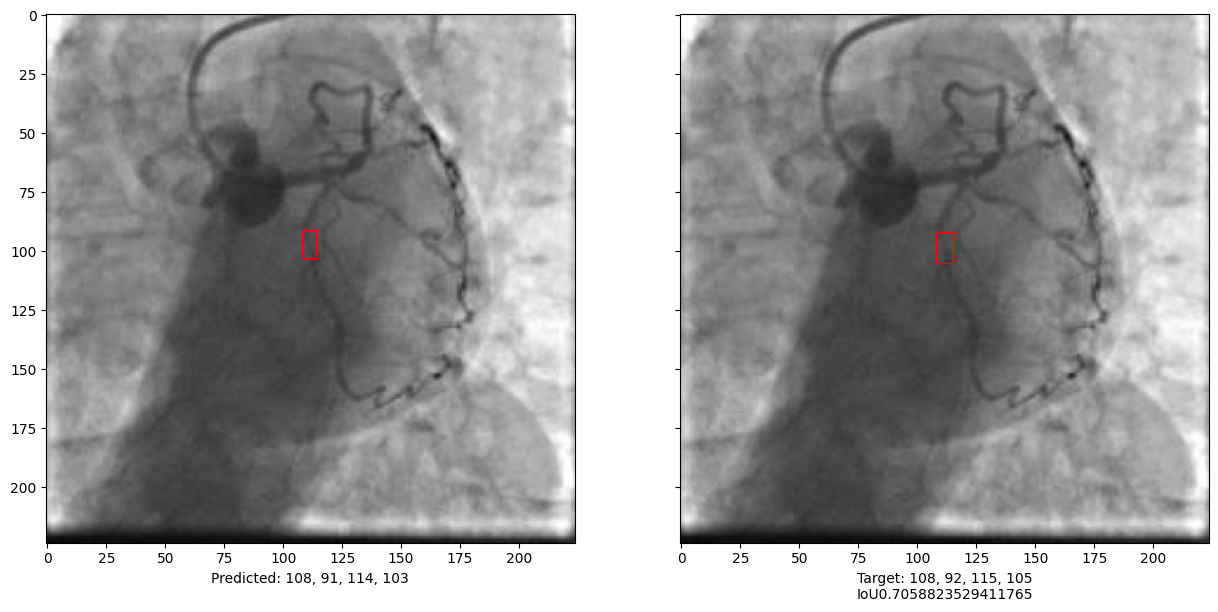

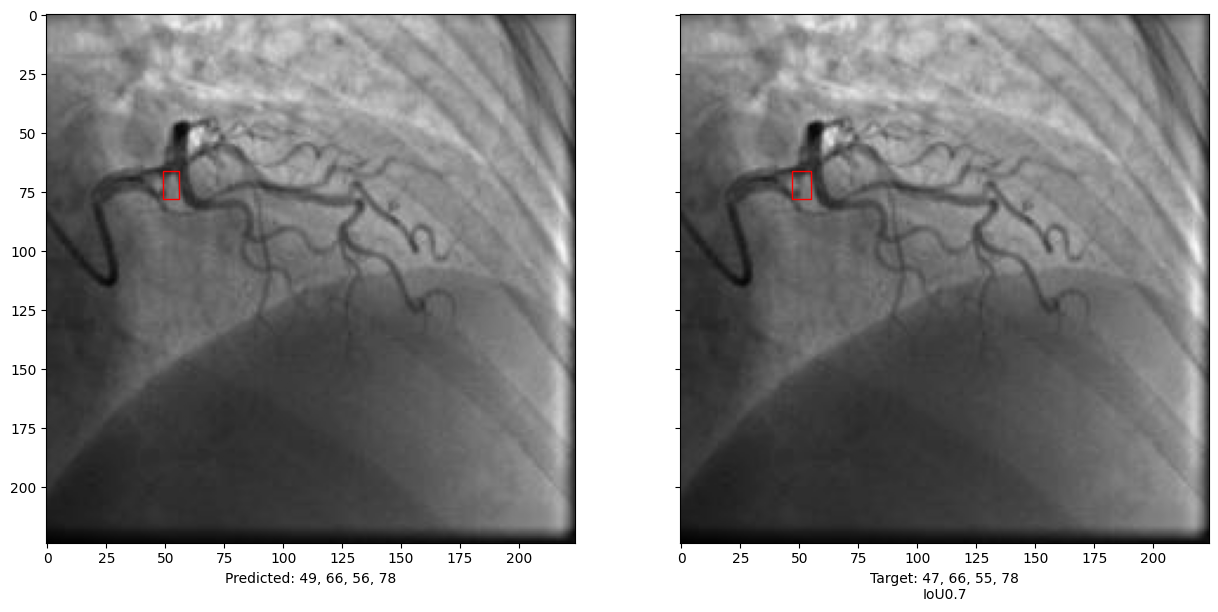

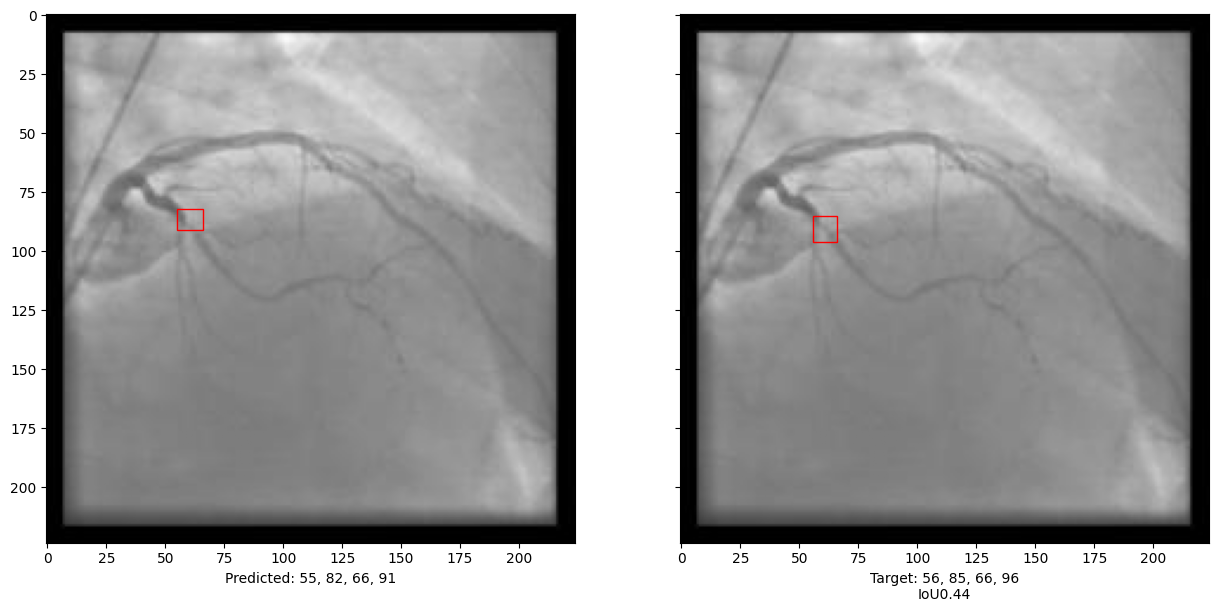

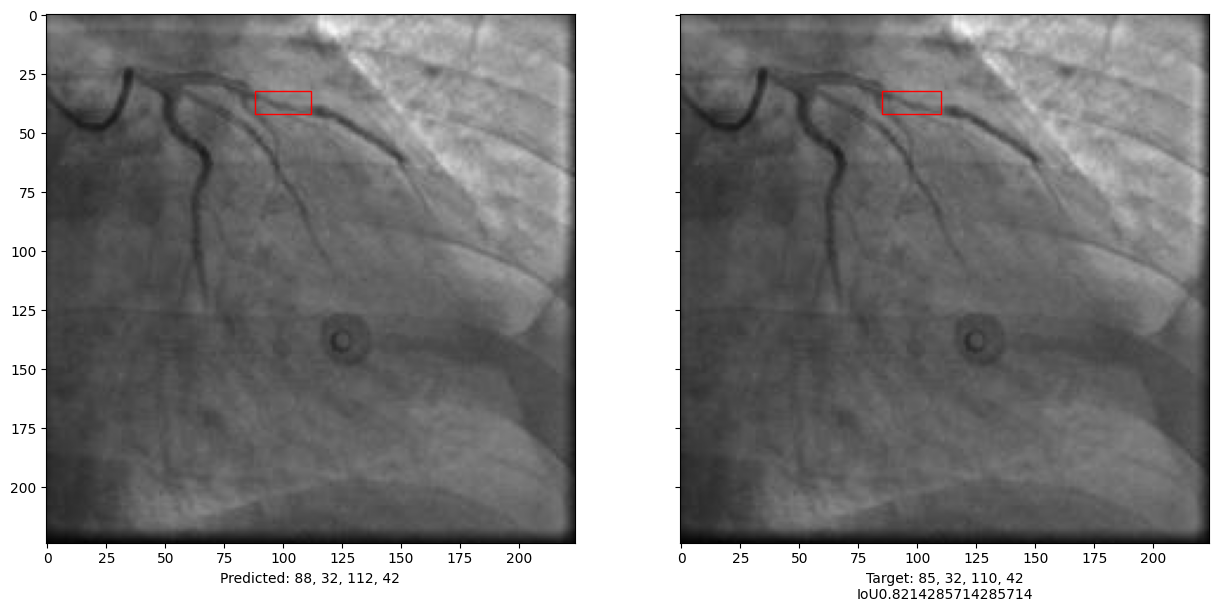

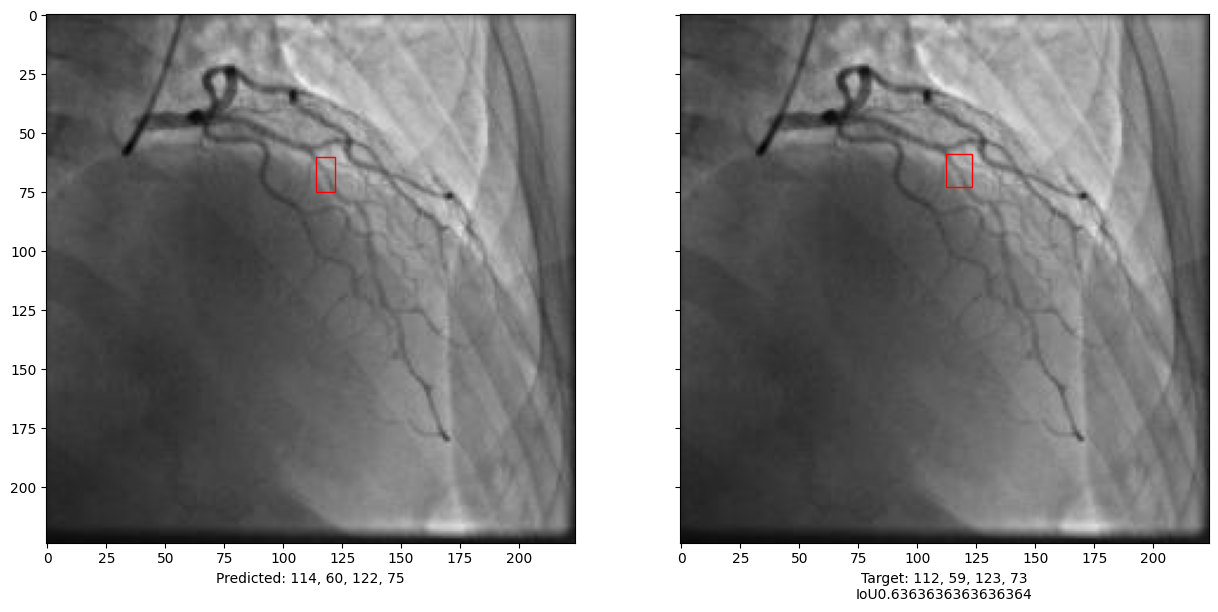

In [20]:
# Reference: https://keras.io/examples/vision/object_detection_using_vision_transformer/#evaluate-the-model

# To calculate IoU (intersection over union, given two bounding boxes)
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # Get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # Calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # Calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # Calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # Return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in test_images[:15]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)
    im = input_image

    # Display the image
    ax1.imshow(im)
    ax2.imshow(im)

    input_image = cv2.resize(input_image, (224, 224))
    input_image = np.expand_dims(input_image, axis=0)
    preds = model_load.predict(input_image)[0]
    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor='none',
        edgecolor='red',
        linewidth=1,
    )

    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        'Predicted: '
        + str(top_left_x)
        + ', '
        + str(top_left_y)
        + ', '
        + str(bottom_right_x)
        + ', '
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(test_targets[i][0] * w), int(test_targets[i][1] * h)

    bottom_right_x, bottom_right_y = int(test_targets[i][2] * w), int(
        test_targets[i][3] * h
    )

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor='none',
        edgecolor='red',
        linewidth=1,
    )
    
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        'Target: '
        + str(top_left_x)
        + ', '
        + str(top_left_y)
        + ', '
        + str(bottom_right_x)
        + ', '
        + str(bottom_right_y)
        + '\n'
        + 'IoU'
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )

    i = i + 1
plt.show()
